In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import scanpy as sc

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, binarize
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.metrics import roc_auc_score, brier_score_loss

In [31]:
regression = False
classification = True

In [5]:
test_data = pd.read_csv('./Data/test.csv')
print(test_data.shape)

train_data = pd.read_csv('./Data/train.csv')
print(train_data.shape)

(48, 15896)
(380, 15896)


In [32]:
if regression:
    train_features, val_features, train_labels, val_labels = train_test_split(
        train_data.iloc[:, :-3], train_data.iloc[:, -2], test_size=0.2, random_state=42)

    test_features, test_labels = test_data.iloc[:, :-3], test_data.iloc[:, -2]
if classification:
    train_features, val_features, train_labels, val_labels = train_test_split(
        train_data.iloc[:, :-3], train_data.iloc[:, -1], test_size=0.2, random_state=42)

    test_features, test_labels = test_data.iloc[:, :-3], test_data.iloc[:, -1]

In [36]:
model = RandomForestClassifier()

#GradientBoostingClassifier()

#GradientBoostingClassifier()

#LogisticRegression(penalty='l1', solver='liblinear')

clf = make_pipeline(StandardScaler(), model) 

clf.fit(train_features, train_labels)

y_pred = clf.predict(test_features) 

if regression:
    time = y_pred
    rmse = mean_squared_error(test_labels, y_pred, squared=False)
    mae = mean_absolute_error(test_labels, y_pred)
    print("RMSE: ", rmse)
    print("MAE: ", mae)
if classification:
    risk = y_pred
    print(roc_auc_score(test_labels, y_pred))
    print(brier_score_loss(test_labels, y_pred))

0.6727272727272727
0.25


In [35]:
y_pred2 = clf.predict(train_features) 
print(roc_auc_score(train_labels, y_pred2)) # just overfitting - spurious amounts of noise

1.0


In [34]:
def c_index(Prediction, Time_survival, Death): #, Time
    '''
        This is a cause-specific c(t)-index
        - Prediction      : risk at Time (higher --> more risky)
        - Time_survival   : survival/censoring time
        - Death           :
            > 1: death
            > 0: censored (including death from other cause)
        - Time            : time of evaluation (time-horizon when evaluating C-index)
    '''
    N = len(Prediction)
    A = np.zeros((N,N))
    Q = np.zeros((N,N))
    N_t = np.zeros((N,N))
    Num = 0
    Den = 0
    for i in range(N):
        A[i, np.where(Time_survival[i] < Time_survival)] = 1
        Q[i, np.where(Prediction[i] > Prediction)] = 1
  
        if Death[i]==1: #(Time_survival[i]<=Time and
            N_t[i,:] = 1

    Num  = np.sum(((A)*N_t)*Q)
    Den  = np.sum((A)*N_t)

    if Num == 0 and Den == 0:
        result = -1 # not able to compute c-index!
    else:
        result = float(Num/Den)

    return result
print(c_index(risk, time, test_labels))

0.46176470588235297


In [ ]:
scores = cross_val_score(clf, train_features, train_labels, cv=10, scoring=make_scorer(mean_squared_error))
scores = np.sqrt(scores)
sem = stats.sem(scores)
print(f"Mean RMSE with 95% CI: {np.mean(scores):.3f} ± {sem * 1.96:.3f}")

/var/folders/ly/v37s6hc13892_26xv925209r0000gn/T/ipykernel_56529/518801643.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


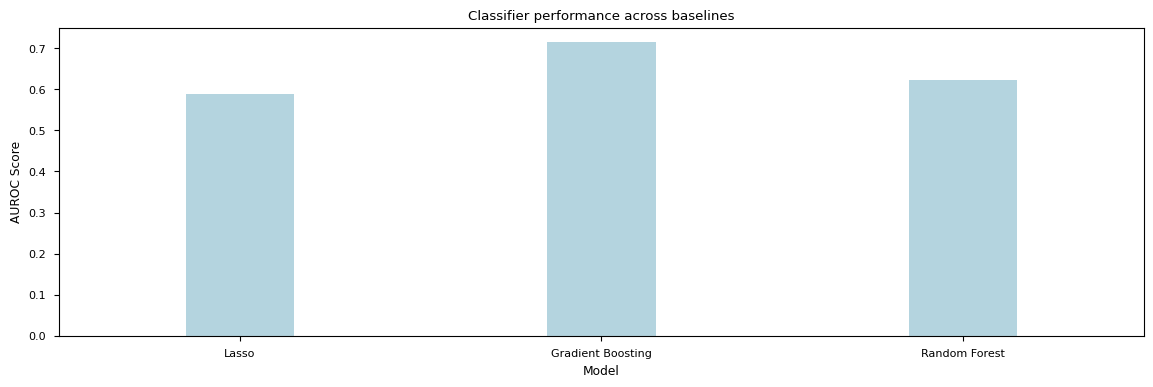

In [78]:
plt.figure(figsize=(14, 4))
plt.style.use("seaborn-paper")
sns.barplot(x=["Lasso", "Gradient Boosting", "Random Forest"], y=[0.5872235872235871, 0.7137592137592138, 0.6228501228501229],color="lightblue", width=0.3)
plt.xlabel('Model')
plt.ylabel('AUROC Score')
plt.title('Classifier performance across baselines')
plt.rcParams['savefig.dpi']=300
plt.savefig("baselines2.png")

/var/folders/ly/v37s6hc13892_26xv925209r0000gn/T/ipykernel_56529/3148870556.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


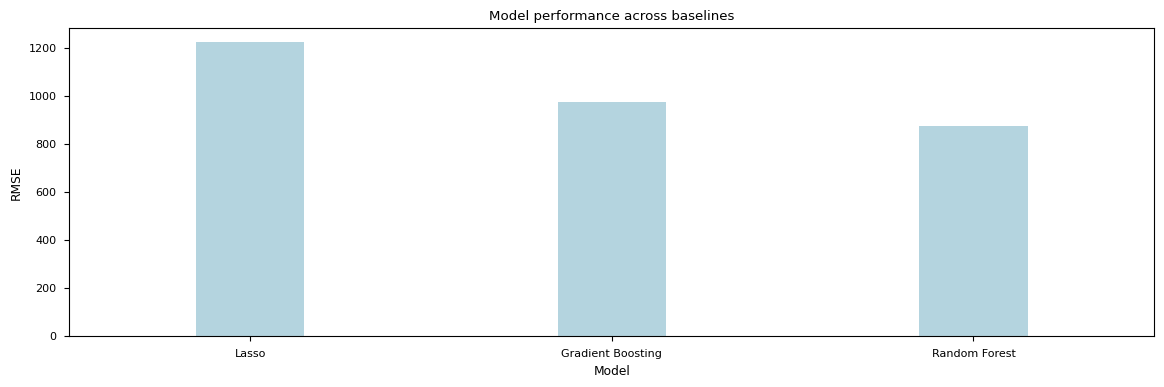

In [79]:
# Test out random noise
plt.figure(figsize=(14, 4))
plt.style.use("seaborn-paper")
sns.barplot(x=["Lasso", "Gradient Boosting", "Random Forest"], y=[1221.1997312374897, 973.7958962915109, 874.9631619459758],color="lightblue", width=0.3)
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Model performance across baselines')
plt.rcParams['savefig.dpi']=300
plt.savefig("baselines.png")

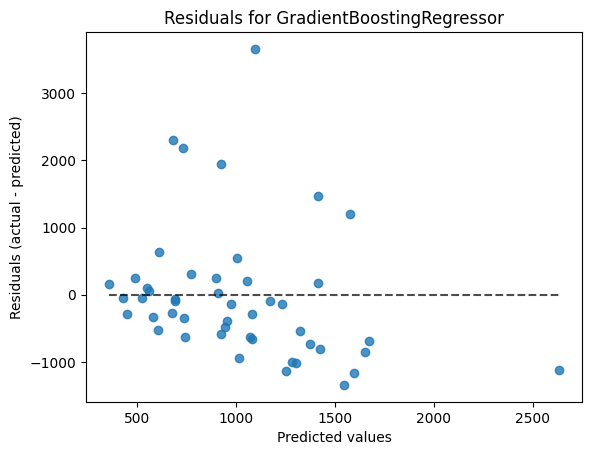

In [27]:
from sklearn.metrics import PredictionErrorDisplay
display = PredictionErrorDisplay(y_true = test_labels, y_pred=y_pred)
display.plot()
plt.title(f"Residuals for {model.__class__.__name__}")
plt.show()

In [3]:
strings = ['FGFR3','CUL7','HPD','SLC35D2','ACYP2','CADM1','RBKS','DUSP6','MRC2','CDH6','TLE4','TMOD1','P2RY1','HDC','CFLAR','CHRNA9','MAP3K13','HTR3B','ACACB','SPRY1','THBS4','PNMT','CASP4','GRB7','TUBB1','VAV3','DUSP10','CFTR','SFRP4','GABRB2','LAMA2','DYNLL1','PXN','MRAS','CDKN2C','SLIT2','RIPK1','ABCB4','ST6GALNAC5','SLC6A20','GAS2','MEF2C','FMOD','CD9','PCSK1','RGS3','TRADD','ST8SIA5','SOCS3','CDO1','HIST1H3G','OPRL1','ZYX','MCFD2','ITGB3','CLCF1','ITGAX','ATP8B1','CCL16','SULT2B1','PITPNA','LAP3','PIGT','COL19A1','BDKRB2','ADCYAP1','TRAT1','KIAA1598','BDNF','ARG2','SSH3','C9','CFH','CKM','MMP3','DLC1','CRTAM','DNMT3L','HNF4A','SLC27A6','TNNI2','KCNMB1','CLDN10','CAPN2','ABCA12','IRF2','LEPR','HRH1','ALDOB','EPHB6','ARSB','OR51E2','CDH11','FZD10','GMPR','PDGFA','CCR6','ARF1','CACNB2','ENPP2']
strings = ['EPN3','MAFG','PRKAR1B','TBKBP1','KCNH4','ALLC','GPR44','SLC17A7','GPER','SEMA3G','FGF18','CAMK2B','RPL10L','HCN2','ARFGAP1','GRM4','MAPK8IP3','NDEL1','DGKZ','CACNB2','FGF6','CACNB1','KCNAB2','IQSEC1','JAG2','TPO','PTPRN2','CSNK1D','EPN1','SEMA6B','SLC2A2','MMP17','UBOX5','HAO1','COL6A3','PGF','SLC9A3R2','PIN1','ACVR2A','SCN8A','GJA4','LBP','RAP1GAP','RAD52','PRNP','GRM2','PTBP1','ATP2C2','CHMP2A','CDKN1A','DUT','PML','MRAS','HK1','IL13','BNIP1','OPRL1','BAIAP2','SETDB1','RBCK1','ANGPTL4','VDAC3','TOLLIP','CTSL1','LPL','BRCA1','PFKP','WDR61','MUC4','PPP2R2D','KISS1','GPLD1','NPFF','CDC25C','GHRH','RAMP2','POLR2E','PGS1','PLXNA1','MPHOSPH6','FOXH1','ZNF202','AQP7','GAPDHS','RAB3A','TAS2R4','SMUG1','RAB11FIP5','DEFA5','CHRM4','SCN7A','AKR1B10','ENTPD4','CCNB1','TXK','PSMA2','HTR4','CPT1B','MYL2','CTSE']
strings = ['ZNF492','SSTR1','FGFR3','CUL7','HPD','CNTNAP2','RELN','GATA6','SLC35D2','HTR1E','ACYP2','PCSK6','CADM1','OPRK1','RBKS','GABRG2','DUSP6','MRC2','CDH6','TLE4','SMPD3','TMOD1','P2RY1','HDC','CFLAR','CHRNA9','MAP3K13','SYN3','HTR3B','ACACB','GALNT14','SPRY1','THBS4','PNMT','CASP4','GRB7','TUBB1','VAV3','DLL3','DUSP10','CFTR','PDE10A','SFRP4','GABRB2','LAMA2','DKK2','MYOD1','DYNLL1','PXN','CXCL12','MRAS','CDKN2C','RPRM','SLIT2','CACNG2','RIPK1','ABCB4','ST6GALNAC5','SV2C','SLC6A20','GAS2','TACR1','ITGA8','MEF2C','HIST3H2A','FGF5','CRH','FMOD','CALCR','SLC25A21','CD9','ZNF274','PCSK1','RGS3','PKP2','TRADD','ST8SIA5','SOCS3','CDO1','HIST1H3G','SFRP1','OPRL1','GDNF','ACAN','ZNF544','RXFP3','ZYX','MCFD2','BMP4','ITGB3','CLCF1','FZD9','ITGAX','ATP8B1','CCL16','SULT2B1','KCNA4','PITPNA','ST8SIA2','LAP3']
for s in strings:
    print(s)

ZNF492
SSTR1
FGFR3
CUL7
HPD
CNTNAP2
RELN
GATA6
SLC35D2
HTR1E
ACYP2
PCSK6
CADM1
OPRK1
RBKS
GABRG2
DUSP6
MRC2
CDH6
TLE4
SMPD3
TMOD1
P2RY1
HDC
CFLAR
CHRNA9
MAP3K13
SYN3
HTR3B
ACACB
GALNT14
SPRY1
THBS4
PNMT
CASP4
GRB7
TUBB1
VAV3
DLL3
DUSP10
CFTR
PDE10A
SFRP4
GABRB2
LAMA2
DKK2
MYOD1
DYNLL1
PXN
CXCL12
MRAS
CDKN2C
RPRM
SLIT2
CACNG2
RIPK1
ABCB4
ST6GALNAC5
SV2C
SLC6A20
GAS2
TACR1
ITGA8
MEF2C
HIST3H2A
FGF5
CRH
FMOD
CALCR
SLC25A21
CD9
ZNF274
PCSK1
RGS3
PKP2
TRADD
ST8SIA5
SOCS3
CDO1
HIST1H3G
SFRP1
OPRL1
GDNF
ACAN
ZNF544
RXFP3
ZYX
MCFD2
BMP4
ITGB3
CLCF1
FZD9
ITGAX
ATP8B1
CCL16
SULT2B1
KCNA4
PITPNA
ST8SIA2
LAP3
